## Detecting Twitter Bots

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from nltk import FreqDist
import re
import spacy
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.metrics import precision_score,recall_score,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import VotingClassifier

import warnings
warnings.filterwarnings("ignore")  

In [7]:
training_data = pd.read_csv('./training_data_2_csv_UTF.csv')
bots = training_data[training_data.bot==1]
nonbots = training_data[training_data.bot==0]

In [8]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2797 entries, 0 to 2796
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2797 non-null   float64
 1   id_str                 2797 non-null   object 
 2   screen_name            2797 non-null   object 
 3   location               1777 non-null   object 
 4   description            2394 non-null   object 
 5   url                    1375 non-null   object 
 6   followers_count        2797 non-null   int64  
 7   friends_count          2797 non-null   int64  
 8   listed_count           2797 non-null   int64  
 9   created_at             2797 non-null   object 
 10  favourites_count       2797 non-null   int64  
 11  verified               2797 non-null   bool   
 12  statuses_count         2797 non-null   int64  
 13  lang                   2797 non-null   object 
 14  status                 2461 non-null   object 
 15  defa

In [50]:
len(training_data)

2797

In [9]:
training_data.head()

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1
1,4.843621e+09,4843621225,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,1,349,0,02/01/16 7:37,38,False,31,en,NaN,True,False,False,Keri Nelson,1
2,4.303727e+09,4303727112,mattlieberisbot,NaN,"Inspired by the inspiring smart, funny folks a...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1
3,3.063139e+09,3063139353,sc_papers,NaN,NaN,NaN,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers,1
4,2.955142e+09,2955142070,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,11,745,0,01/01/15 17:44,146,False,185,en,NaN,False,False,False,lucarivera16,1



### Exploratory Data Analysis



#### Identifying Missingness in the data

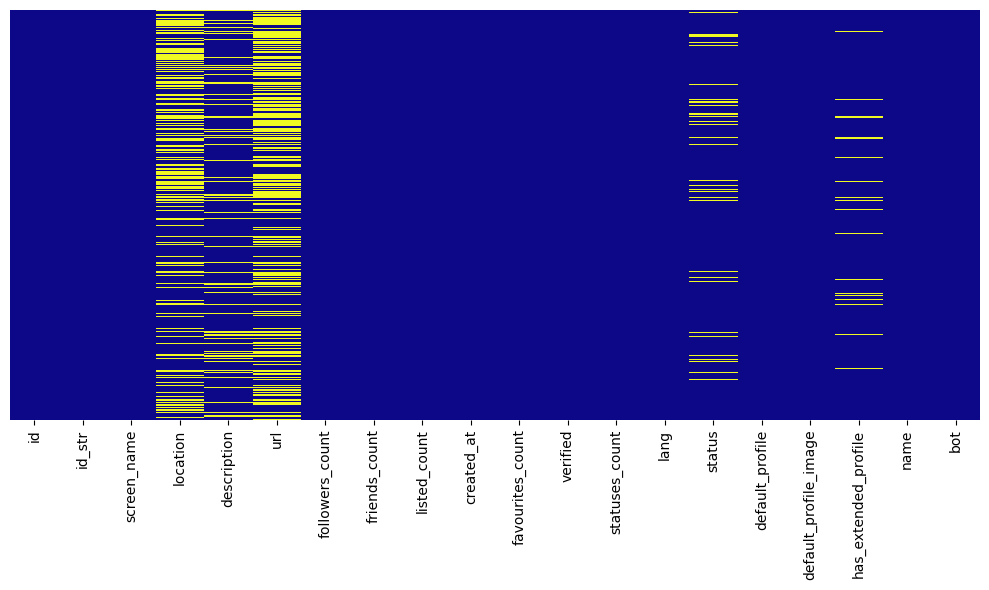

In [10]:
def get_heatmap(df):
    #This function gives heatmap of all NaN values
    plt.figure(figsize=(10,6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='plasma')
    plt.tight_layout()
    return plt.show()

get_heatmap(training_data)

#### Identifying Imbalance in the data

In [11]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

nonbots['friends_by_followers'] = nonbots.friends_count/nonbots.followers_count
nonbots[nonbots.friends_by_followers<1].shape

(952, 21)

(504, 21)


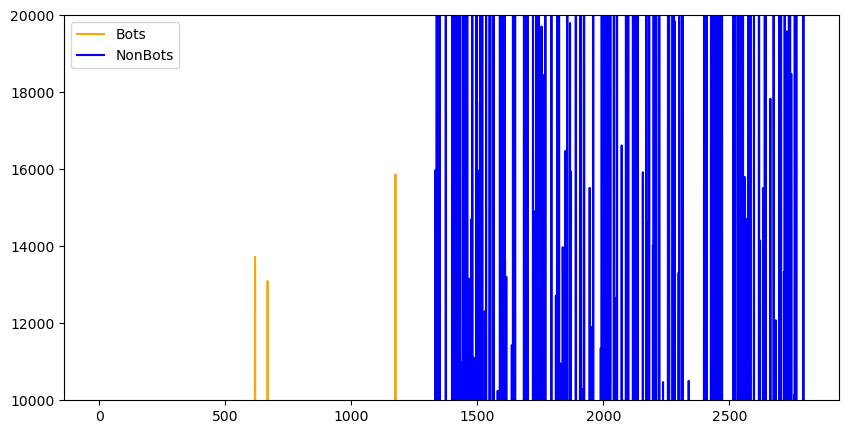

In [12]:
plt.figure(figsize=(10,5))
plt.plot(bots.listed_count, color='orange', label='Bots')
plt.plot(nonbots.listed_count, color='blue', label='NonBots')
plt.legend(loc='upper left')
plt.ylim(10000,20000)
print(bots[(bots.listed_count<5)].shape)

In [13]:
bots_listed_count_df = bots[bots.listed_count<16000]
nonbots_listed_count_df = nonbots[nonbots.listed_count<16000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape

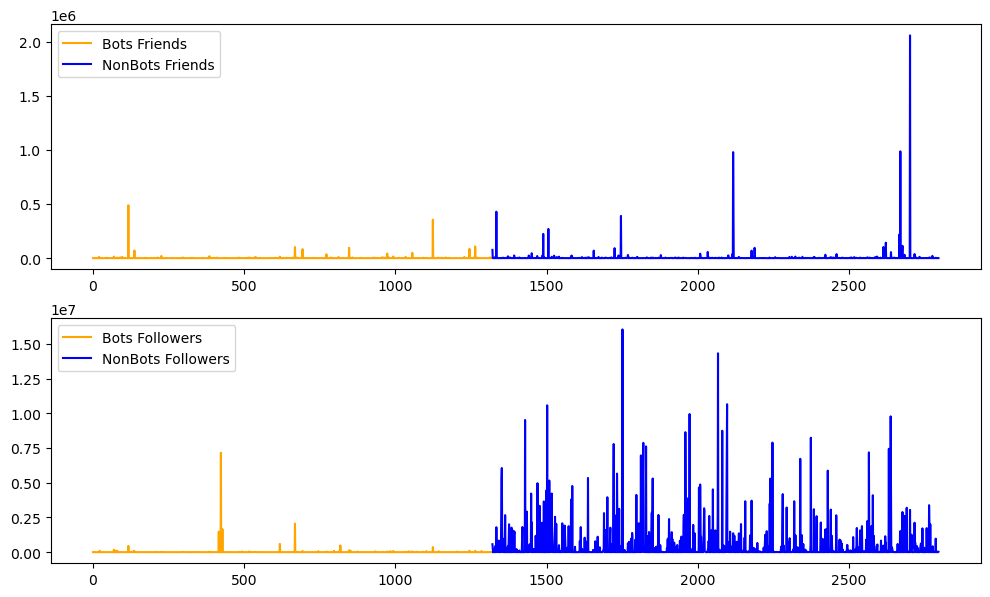

In [14]:
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(bots_listed_count_df.friends_count, color='orange', label='Bots Friends')
plt.plot(nonbots_listed_count_df.friends_count, color='blue', label='NonBots Friends')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(bots_listed_count_df.followers_count, color='orange', label='Bots Followers')
plt.plot(nonbots_listed_count_df.followers_count, color='blue', label='NonBots Followers')
plt.legend(loc='upper left')

In [15]:
#bots[bots.listedcount>10000]
condition = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.description.str.contains("bot", case=False)==True)|(bots.location.isnull())|(bots.verified==False)

bots['screen_name_binary'] = (bots.screen_name.str.contains("bot", case=False)==True)
bots['location_binary'] = (bots.location.isnull())
bots['verified_binary'] = (bots.verified==False)
bots.shape

(1321, 24)

In [16]:
condition = (nonbots.screen_name.str.contains("bot", case=False)==False)| (nonbots.description.str.contains("bot", case=False)==False) |(nonbots.location.isnull()==False)|(nonbots.verified==True)

nonbots['screen_name_binary'] = (nonbots.screen_name.str.contains("bot", case=False)==False)
nonbots['location_binary'] = (nonbots.location.isnull()==False)
nonbots['verified_binary'] = (nonbots.verified==True)

nonbots.shape

(1476, 24)

In [17]:
df = pd.concat([bots, nonbots])
df.shape

(2797, 24)

## Implementing Different Models

#### Additional Functions

In [18]:
def remove_stopwords(rev):
    rev_new =[]
    for sentence in rev:
        for word in sentence:
            #rev_new_word = []
            if word not in stopwords.words('english'):
                rev_new.append(word)
        #rev_new.append(rev_new_word)
    return rev_new
    #rev_new = " ".join([i for i in rev if i not in stop_words])
   # return rev_new

In [19]:
tweets_data = []
x = []
y = []
dataset = []
all_words = []
vectorizer = CountVectorizer(stop_words='english')

def retrieveProcessedData(Pdata_url,row_num):
    with open(Pdata_url, 'r', encoding="latin-1") as csvfile:
        csvreader = csv.reader(csvfile)
        c = 0
        for row in csvreader:
            if row[19] == '0':
                continue
            y = row[row_num]
            if(len(y)==0):
                continue
            if(c==1):
                print(y)
            c = c+1
            if(c == 10000):
                break
            y = re.sub('[^A-Za-z0-9 ]+', '', y)
            y = y.replace("@", "")
            y = y.replace("n\'t", " not")
            y = re.sub(r"http\S+", "", y)
            y = re.sub(r'\b\b', '', y)
            y = y.lower()
            x.append(y)
        

In [20]:
# function to plot most frequent terms
def freq_words(x, terms = 50):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  d = words_df.nlargest(columns="count", n = terms) 
  
  bag_array = d['word'].to_numpy()
  #print(bag_array)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()
  return bag_array
    

In [23]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [21]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    #print(output)
    return output

In [22]:
def preprocessing():
    tokenized_reviews = pd.Series(x).apply(lambda t: t.split())
    reviews = lemmatization(tokenized_reviews)
    reviews_3 = []
    for i in range(len(reviews)):
        reviews_3.append(' '.join(reviews[i]))
    dataset = reviews_3
    bag_array = []
    bag_array = freq_words(dataset, 20)
    s = ''
    for ele in bag_array :
        s += ele
        s += '|'
    s = s[:-1] 
    return s

"HoustonPokeMap"


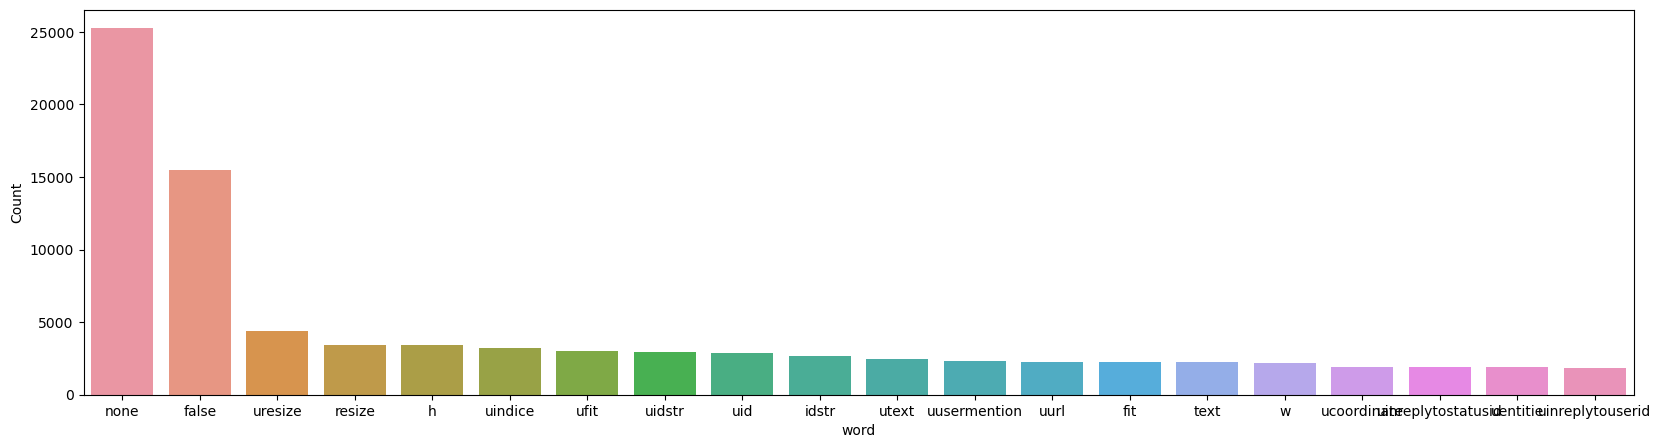

this is s : none|false|uresize|resize|h|uindice|ufit|uidstr|uid|idstr|utext|uusermention|uurl|fit|text|w|ucoordinate|uinreplytostatusid|uentitie|uinreplytouserid
"Rare and strong PokÅ½mon in Houston, TX. See more PokÅ½mon at https://t.co/dnWuDbFRkt"


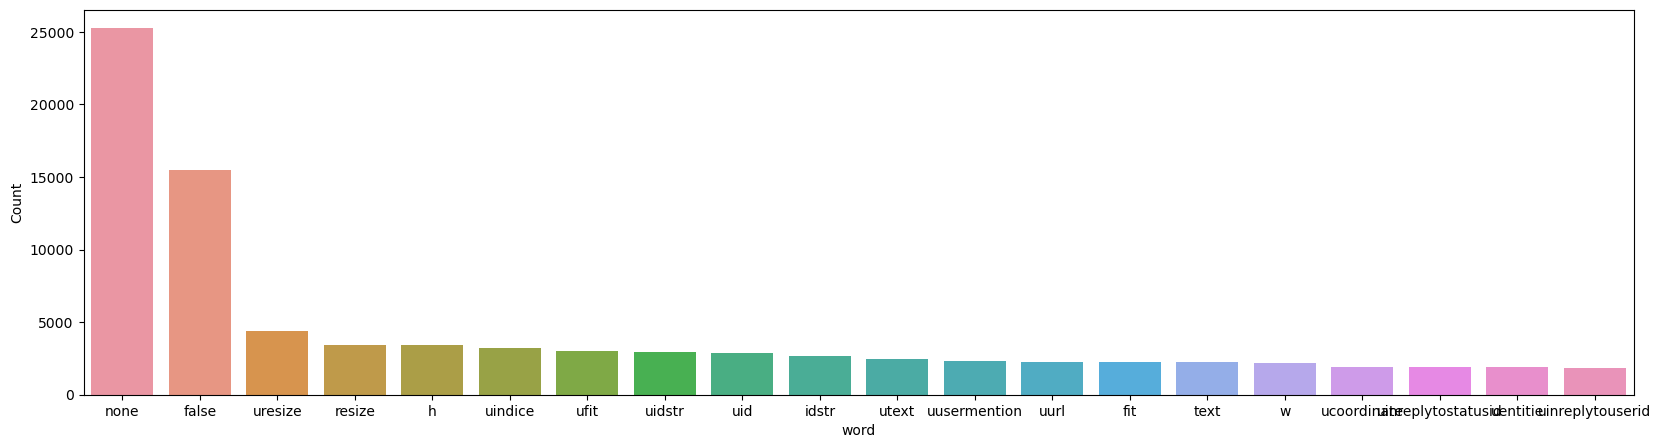

{
      "created_at": "Sun Mar 12 15:44:04 +0000 2017",
      "id": 840951532543737900,
      "id_str": "840951532543737856",
      "text": "[Southeast Houston] Chansey (F) (IV: 73%) until 11:11:37AM at 2511 Winbern St https://t.co/HYRIyq4mF7 https://t.co/bydOOKsEEI",
      "truncated": false,
      "entities":  {
        "hashtags":  [],
        "symbols":  [],
        "user_mentions":  [],
        "urls":  [
           {
            "url": "https://t.co/HYRIyq4mF7",
            "expanded_url": "https://houstonpokemap.com/#29.73067033,-95.36610821",
            "display_url": "houstonpokemap.com/#29.73067033,-Ã",
            "indices":  [
              78,
              101
            ]
          },
           {
            "url": "https://t.co/bydOOKsEEI",
            "expanded_url": "https://maps.google.com/maps?q=29.73067033,-95.36610821",
            "display_url": "maps.google.com/maps?q=29.7306Ã",
            "indices":  [
              102,
              125
            ]
  

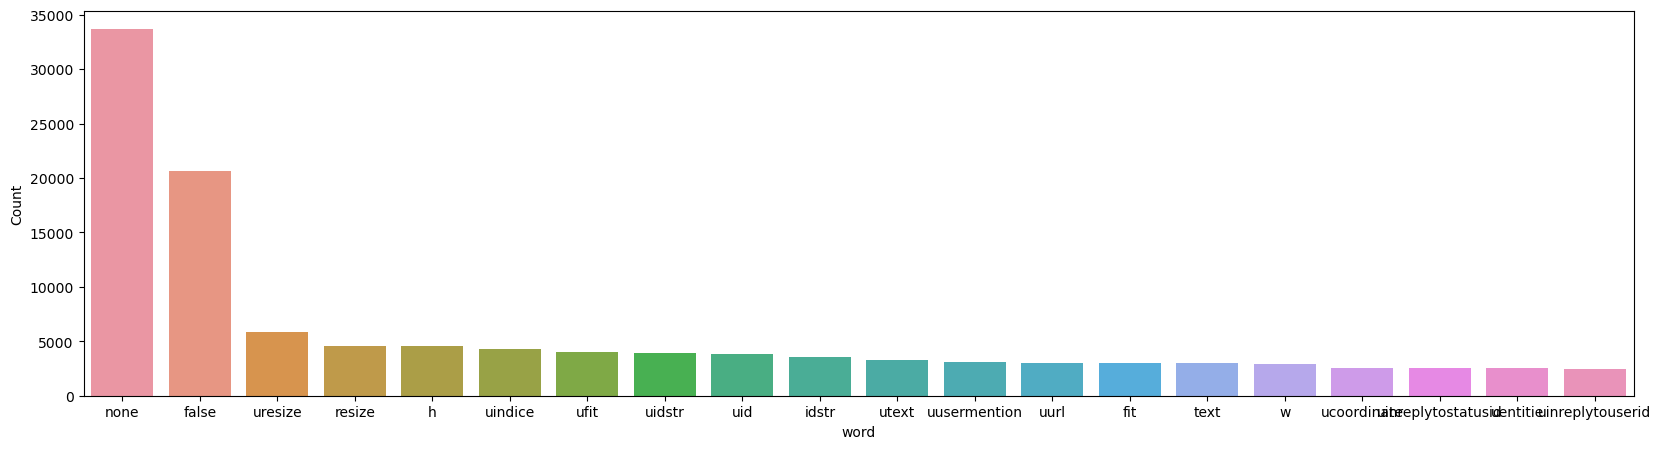

"Houston PokÅ½ Alert"


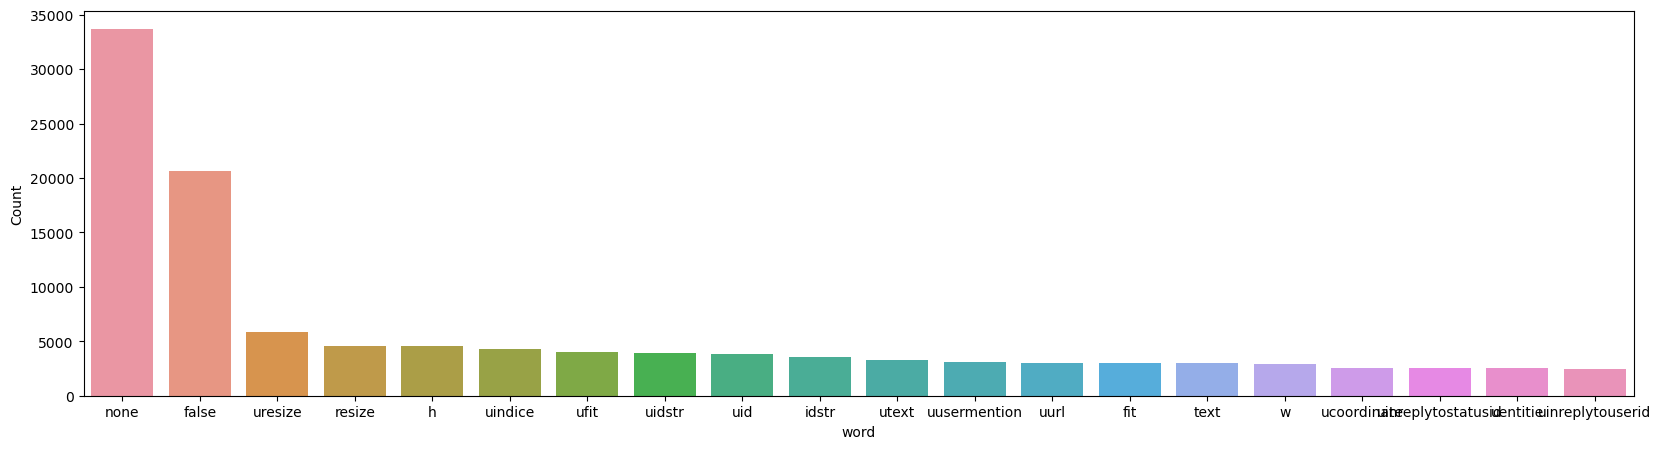

In [32]:
bag_description = [] #4
bag_screen_name = [] #2
bag_name = [] #18
bag_status = [] 

def runall():
    retrieveProcessedData('training_data_2_csv_UTF.csv',2)
    s = preprocessing()
    training_data['screen_name_binary'] = training_data.description.str.contains(s, case=False, na=False)
    retrieveProcessedData('training_data_2_csv_UTF.csv',4)
    s = preprocessing()
    training_data['description_binary'] = training_data.description.str.contains(s, case=False, na=False)
    
    retrieveProcessedData('training_data_2_csv_UTF.csv',14)
    s = preprocessing()
    training_data['status_binary'] = training_data.description.str.contains(s, case=False, na=False)
    
    retrieveProcessedData('training_data_2_csv_UTF.csv',18)
    s = preprocessing()
    training_data['name_binary'] = training_data.description.str.contains(s, case=False, na=False)
runall()

In [26]:
# training_data['screen_name_binary']
# training_data['name_binary']
# training_data['description_binary']
# training_data['status_binary']

In [ ]:
training_data

In [33]:
training_data['listed_count_binary'] = (training_data.listed_count>20000)==False
features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

In [30]:
training_data[features]

,screen_name_binary,name_binary,description_binary,status_binary,verified,followers_count,friends_count,statuses_count,listed_count_binary,bot
0,True,True,True,True,False,1291,0,78554,True,1
1,True,True,True,True,False,1,349,31,True,1
2,True,True,True,True,False,1086,0,713,True,1
3,False,False,False,False,False,33,0,676,True,1
4,True,True,True,True,False,11,745,185,True,1
...,...,...,...,...,...,...,...,...,...,...
2792,True,True,True,True,False,18998,2005,3498,True,0
2793,True,True,True,True,False,32,54,97,True,0
2794,True,True,True,True,True,45044433,7451,9606,False,0
2795,True,True,True,True,False,16,64,62,True,0


In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split,GridSearchCV

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10,class_weight='balanced')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
#X_train = X
#y_train = y
dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.86817
Test Accuracy: 0.87262


In [36]:
params_list = {'min_samples_leaf':[50,100,150,200,250],'min_samples_split':[10,11,12,13,14,15,20]}


In [37]:
grid_search_dt = GridSearchCV(dt,param_grid=params_list,cv=3)

In [38]:
grid_search_dt.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='entropy',
                                              min_samples_leaf=50,
                                              min_samples_split=10),
             param_grid={'min_samples_leaf': [50, 100, 150, 200, 250],
                         'min_samples_split': [10, 11, 12, 13, 14, 15, 20]})

In [41]:
best_dt = DecisionTreeClassifier(min_samples_leaf=100,min_samples_split=10)

In [42]:
best_dt.fit(X_train,y_train)
y_pred_train = best_dt.predict(X_train)
y_pred_test = best_dt.predict(X_test)

print("Trainig Accuracy after Hyperparameter Tuning: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy after Hyperparameter Tuning: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy after Hyperparameter Tuning: 0.83240
Test Accuracy after Hyperparameter Tuning: 0.83095


In [29]:
print("Training Precision: %.5f" %precision_score(y_train,y_pred_train))
print("Testing Precision: %.5f" %precision_score(y_test,y_pred_test))
print("Training Recall: %.5f" %recall_score(y_train,y_pred_train))
print("Training Recall: %.5f" %recall_score(y_test,y_pred_test))

Training Precision: 0.87861
Testing Precision: 0.87940
Training Recall: 0.84071
Training Recall: 0.83933


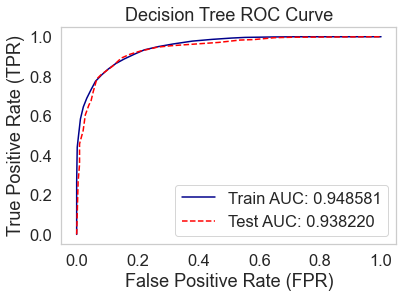

In [92]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = dt.predict_proba(X_train)
scores_test = dt.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_dt_train, tpr_dt_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

In [44]:
from sklearn.ensemble import RandomForestClassifier

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))
print("Training Precision: %.5f" %precision_score(y_train,y_pred_train))
print("Testing Precision: %.5f" %precision_score(y_test,y_pred_test))
print("Training Recall: %.5f" %recall_score(y_train,y_pred_train))
print("Training Recall: %.5f" %recall_score(y_test,y_pred_test))

Trainig Accuracy: 0.85028
Test Accuracy: 0.84048
Training Precision: 0.88720
Testing Precision: 0.89636
Training Recall: 0.77434
Training Recall: 0.76739


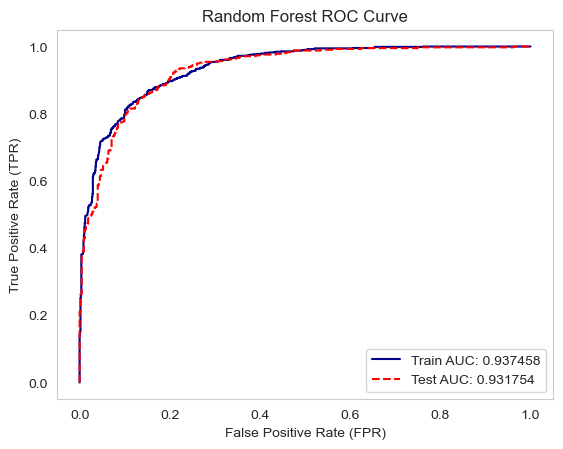

In [45]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rf.predict_proba(X_train)
scores_test = rf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

In [46]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(criterion='entropy', min_samples_leaf=100,
                       min_samples_split=20)>

In [47]:
params_list_rf = {'n_estimators':np.arange(50,200,10),
    'criterion':['gini','entropy'],
    'min_samples_split':np.arange(15,30),
    'min_samples_leaf':[100,200,300,400,500]
}

grid_search_rf = GridSearchCV(rf,param_grid=params_list_rf,cv=3)

grid_search_rf.fit(X_train,y_train)
grid_search_rf.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 100,
 'min_samples_split': 27,
 'n_estimators': 60}

In [49]:
best_rf = RandomForestClassifier(criterion='entropy',min_samples_leaf=100,min_samples_split=27,n_estimators=60)
best_rf.fit(X_train,y_train)
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

print("Trainig Accuracy after Hyperparameter Tuning: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy after Hyperparameter Tuning: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy after Hyperparameter Tuning: 0.85386
Test Accuracy after Hyperparameter Tuning: 0.84881


In [97]:
from xgboost import XGBClassifier


X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))
print("Training Precision: %.5f" %precision_score(y_train,y_pred_train))
print("Testing Precision: %.5f" %precision_score(y_test,y_pred_test))
print("Training Recall: %.5f" %recall_score(y_train,y_pred_train))
print("Training Recall: %.5f" %recall_score(y_test,y_pred_test))

Trainig Accuracy: 0.98808
Test Accuracy: 0.83571
Training Precision: 0.99230
Testing Precision: 0.84559
Training Recall: 0.98222
Training Recall: 0.82143


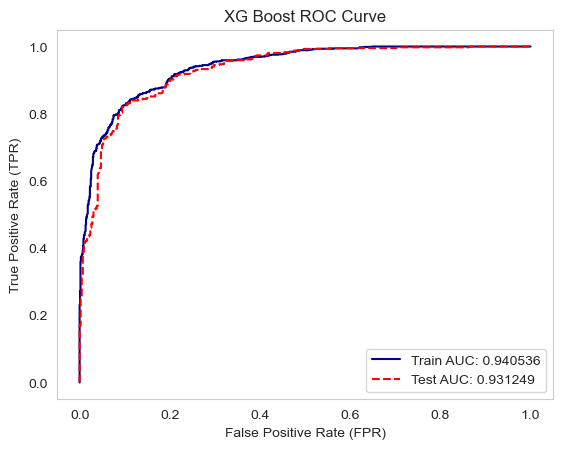

In [38]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rf.predict_proba(X_train)
scores_test = rf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("XG Boost ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')